In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cd /content/drive/MyDrive/
! ls


drive  sample_data


In [ ]:
! cp /content/drive/MyDrive/kaggle.json /content/

In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import numpy as np, pandas as pd, os, glob, cv2
from torch.utils.data import TensorDataset,DataLoader,Dataset
from copy import deepcopy
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Get dataset

In [ ]:
!git clone https://github.com/udacity/P1_Facial_Keypoints.git
!cd P1_Facial_Keypoints
root_dir = 'P1_Facial_Keypoints/data/training/'
all_img_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
data = pd.read_csv('P1_Facial_Keypoints/data/training_frames_keypoints.csv')

Cloning into 'P1_Facial_Keypoints'...
remote: Enumerating objects: 6046, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 6046 (delta 1), reused 3 (delta 0), pack-reused 6038
Receiving objects: 100% (6046/6046), 329.53 MiB | 47.18 MiB/s, done.
Resolving deltas: 100% (154/154), done.
Updating files: 100% (5805/5805), done.


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import cv2, numpy as np
from copy import deepcopy

class FacesData(Dataset):
    def __init__(self, df):
        super(FacesData).__init__()
        self.df = df
        # TODO normalize after calculation of mean and std of images
        self.normalize = transforms.Normalize(mean=[0.2483, 0.2740, 0.3255],
                                               std=[0.2540, 0.2581, 0.2954])
        #self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
         #                                     std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[index,0]
        img = cv2.imread(img_path) / 255.
        kp = deepcopy(self.df.iloc[index, 1:].tolist())
        kp_x = (np.array(kp[0::2])/img.shape[1]).tolist()
        kp_y = (np.array(kp[1::2])/img.shape[0]).tolist()

        kp2 = kp_x + kp_y   # concat x and y positions
        kp2 = torch.tensor(kp2)
        img = self._preprocess_input(img)
        return img, kp2


    def _preprocess_input(self, img):
        img = cv2.resize(img, (224, 224))
        img = torch.tensor(img).permute(2, 0, 1)  # HxWxC to CxHxW
        img = self.normalize(img).float()
        return img.to(device)

    def load_image(self, index):
        img_path = 'P1_Facial_Keypoints/data/training/' + self.df.iloc[index,0]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255.
        img = cv2.resize(img, (224, 224))
        return img

## Read Data

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=101)
train_dataset = FacesData(train.reset_index(drop=True))
test_dataset = FacesData(test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

## Calculate mean and STD of image values

In [ ]:
psum = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

for idx, inputs in enumerate(train_loader):
    # inputs[0]: image with shape [B, C, H, W]
    psum += inputs[0].sum(axis = [0,2,3])
    psum_sq += (inputs[0] ** 2).sum(axis=[0,2,3])

print(psum)

count = len(data) * 224 * 224
total_mean = psum / count
total_var = (psum_sq / count) - (total_mean ** 2)
total_std = torch.sqrt(total_var)
print(f'{total_mean=}')
print(f'{total_std=}')

RuntimeError: ignored

## Model definition

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False

    model.avgpool = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
                                  nn.MaxPool2d(2),
                                  nn.Flatten())

    model.classifier = nn.Sequential(nn.Linear(in_features=2048, out_features=512),
                                     nn.ReLU(),
                                     nn.Dropout(0.5),
                                     nn.Linear(512, 136),
                                     nn.Sigmoid())

    #  the expected output will always be between 0 and 1 as keypoint locations \\
    #  are a fraction of the original image's dimensions

    # Loss and optimizer
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
    return model.to(device), criterion, optimizer


In [ ]:
model, criterion, optimizer = get_model()

## Train and validation definition

In [ ]:
# A mini-batch training process
def train_batch(images, keypoints, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    predicted_kps = model(images.to(device))
    loss = criterion(predicted_kps, keypoints.to(device))
    loss.backward()
    optimizer.step()
    return loss


# A mini-batch validation process
@torch.no_grad()
def validate_batch(images, keypoints, model, criterion):
    model.eval()
    predicted_kps = model(images.to(device))
    loss = criterion(predicted_kps, keypoints.to(device))
    return predicted_kps, loss




## Create the model and train over epochs

In [ ]:
train_loss, test_loss = [], []

n_epochs = 10
for epoch in range(n_epochs):
    print(f"epoch {epoch+1} of {n_epochs}")
    epoch_train_loss, epoch_valid_loss = 0, 0
    for ix, (img, kps) in enumerate(train_loader):
        loss = train_batch(img, kps, model, optimizer, criterion)
        epoch_train_loss += loss.item()

    epoch_train_loss /= (ix+1)  # Avg loss per sample - normalization of loss

    for ix, (img, kps) in enumerate(test_loader):
        preds, loss = validate_batch(img, kps, model, criterion)
        epoch_valid_loss += loss.item()

    epoch_valid_loss /= (ix+1)
    train_loss.append(epoch_train_loss)
    test_loss.append(epoch_valid_loss)
    print(f"{train_loss=}")
    print(f"{test_loss=}")


epoch 1 of 10
train_loss=[0.058011916648039875]
test_loss=[0.035007998601279476]
epoch 2 of 10
train_loss=[0.058011916648039875, 0.040932032525881956]
test_loss=[0.035007998601279476, 0.02777813197198239]
epoch 3 of 10
train_loss=[0.058011916648039875, 0.040932032525881956, 0.03415569333338189]
test_loss=[0.035007998601279476, 0.02777813197198239, 0.02535155542533506]
epoch 4 of 10
train_loss=[0.058011916648039875, 0.040932032525881956, 0.03415569333338189, 0.030378162925099504]
test_loss=[0.035007998601279476, 0.02777813197198239, 0.02535155542533506, 0.022905997847291557]
epoch 5 of 10
train_loss=[0.058011916648039875, 0.040932032525881956, 0.03415569333338189, 0.030378162925099504, 0.02872251729941231]
test_loss=[0.035007998601279476, 0.02777813197198239, 0.02535155542533506, 0.022905997847291557, 0.0229822951792316]
epoch 6 of 10
train_loss=[0.058011916648039875, 0.040932032525881956, 0.03415569333338189, 0.030378162925099504, 0.02872251729941231, 0.027076666660863776]
test_loss=[0

## Plot train and validation loss over epochs

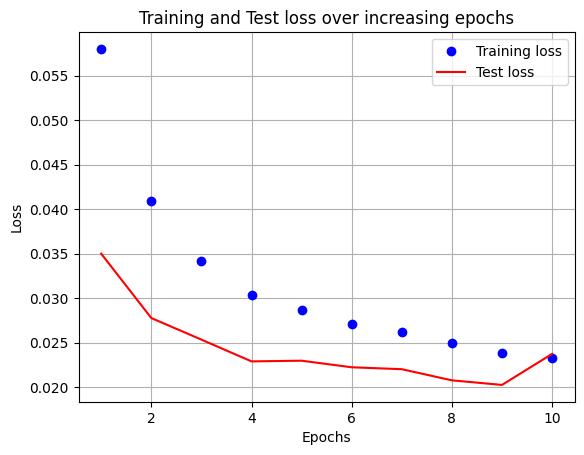

In [ ]:
epochs = np.arange(n_epochs) + 1

import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, test_loss, 'r', label='Test loss')
plt.title('Training and Test loss over increasing epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

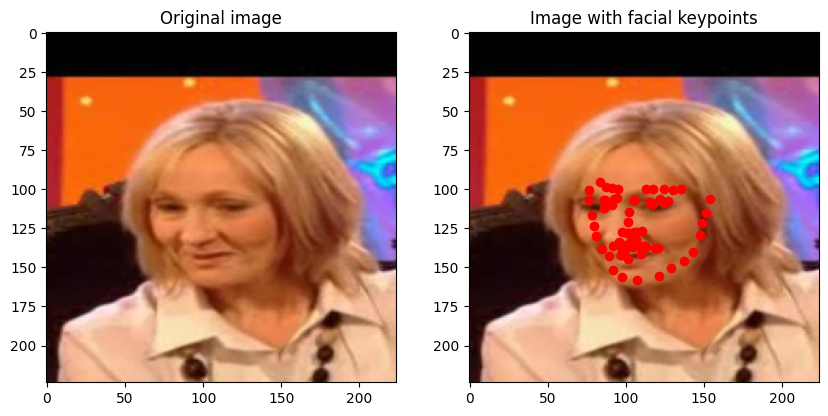

In [ ]:
ix = 0
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Original image')
im = test_dataset.load_image(ix)
plt.imshow(im)
plt.grid(False)
plt.subplot(222)
plt.title('Image with facial keypoints')
x, _ = test_dataset[ix]
plt.imshow(im)
kp = model(x[None]).flatten().detach().cpu()
plt.scatter(kp[:68]*224, kp[68:]*224, c='r')
plt.grid(False)
plt.show()

In [ ]:
arr = np.random.randint(low=1, high=10, size=5)

In [ ]:
arr

array([1, 8, 7, 6, 9])

In [ ]:
torch.sigmoid(torch.from_numpy(arr))

tensor([0.7311, 0.9997, 0.9991, 0.9975, 0.9999])